# Model Comparison for Edge Probability Prediction

This notebook compares 4 different models for predicting edge probabilities based on enhanced degree features:

1. **Simple Neural Network**: 3-layer NN with enhanced features and adaptive architecture
2. **Random Forest**: Ensemble method with 100 trees
3. **Logistic Regression**: Standard logistic regression with L2 regularization
4. **Polynomial Logistic Regression**: Quadratic features + logistic regression

## Enhanced Features

The models now use **18 enhanced features** instead of just 2 basic degree features:
- **Basic degrees**: source_degree, target_degree
- **Normalized degrees**: relative to max and mean degrees
- **Degree interactions**: product, sum, difference
- **Logarithmic transformations**: log(degree), log(product)
- **Centrality measures**: degree density ratios
- **Edge context**: edge density for the edge type

## Adaptive Sampling

The dataset preparation now uses **adaptive sampling** based on edge density:
- **Very sparse edges** (density < 0.0001): 5% negative sampling
- **Sparse edges** (density < 0.001): 2% negative sampling  
- **Dense edges** (density ≥ 0.001): 1% negative sampling

## Workflow

1. **Setup and Data Loading**
2. **Data Preparation with Adaptive Sampling**
3. **Empirical Frequency vs Analytical Comparison**
4. **Model Training with Enhanced Features**
5. **Model Evaluation Statistics and Visualizations**
6. **Model Edge Probability Heatmaps**
7. **Model Predictions vs Analytical**
8. **Model Predictions vs Empirical** 
9. **Enhanced Scatter Plots Colored by Node Features**
10. **Final Summary**
11. **Model Predictions for All Source/Degree Combinations**

In [ ]:
# Papermill parameters
edge_file = "AeG.sparse.npz"  # Default edge file
edge_type = "AeG"  # Default edge type

## 1. Setup and Data Loading

In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import json
import scipy.sparse as sp
warnings.filterwarnings('ignore')

# Setup paths
repo_dir = Path.cwd().parent
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'

sys.path.append(str(src_dir))

# Import our custom modules
from model_comparison import ModelCollection, prepare_edge_features_and_labels, create_degree_grid
from model_training import ModelTrainer, predict_with_model
from model_evaluation import ModelEvaluator, get_best_models
from model_visualization import ModelVisualizer, create_comparison_table_plot
from scatter_plot_helpers import (
    plot_colored_scatter_by_source_degree,
    plot_colored_scatter_by_target_degree,
    plot_colored_scatter_by_degree_product,
    create_model_comparison_grid_with_coloring,
    plot_degree_distribution_comparison
)

print("All modules imported successfully!")
print(f"Repository directory: {repo_dir}")
print(f"Edge processing will be done for edge type: {edge_type}")
print(f"Edge file: {edge_file}")

## 2. Data Preparation

In [ ]:
# Parameters - use papermill parameters for edge file and edge type
EDGE_FILE_PATH = data_dir / 'permutations' / '000.hetmat' / 'edges' / edge_file
EDGE_TYPE = edge_type
SAMPLE_RATIO = 0.01  # Ratio for negative sampling to balance dataset
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Create edge-type-specific results directory
results_dir = repo_dir / 'results' / 'model_comparison' / f'{EDGE_TYPE}_results'
results_dir.mkdir(parents=True, exist_ok=True)

print(f"Processing edge type: {EDGE_TYPE}")
print(f"Loading edge data from: {EDGE_FILE_PATH}")
print(f"File exists: {EDGE_FILE_PATH.exists()}")
print(f"Results will be saved to: {results_dir}")

if not EDGE_FILE_PATH.exists():
    raise FileNotFoundError(f"Edge data file not found: {EDGE_FILE_PATH}")

In [ ]:
# Prepare features and labels with enhanced feature engineering
print("Preparing edge features and labels with enhanced features...")
features, labels = prepare_edge_features_and_labels(
    str(EDGE_FILE_PATH),
    sample_ratio=SAMPLE_RATIO,
    adaptive_sampling=True,
    enhanced_features=True
)

print(f"\nDataset Statistics:")
print(f"  Total samples: {len(features)}")
print(f"  Features shape: {features.shape}")
print(f"  Positive examples: {np.sum(labels)} ({np.mean(labels):.1%})")
print(f"  Negative examples: {len(labels) - np.sum(labels)} ({1-np.mean(labels):.1%})")

print(f"\nFeature Statistics:")
if features.shape[1] >= 2:
    print(f"  Source degrees: {features[:, 0].min():.0f} - {features[:, 0].max():.0f} (mean: {features[:, 0].mean():.1f})")
    print(f"  Target degrees: {features[:, 1].min():.0f} - {features[:, 1].max():.0f} (mean: {features[:, 1].mean():.1f})")
    if features.shape[1] > 2:
        print(f"  Enhanced features: {features.shape[1]} total features including degree interactions and transformations")

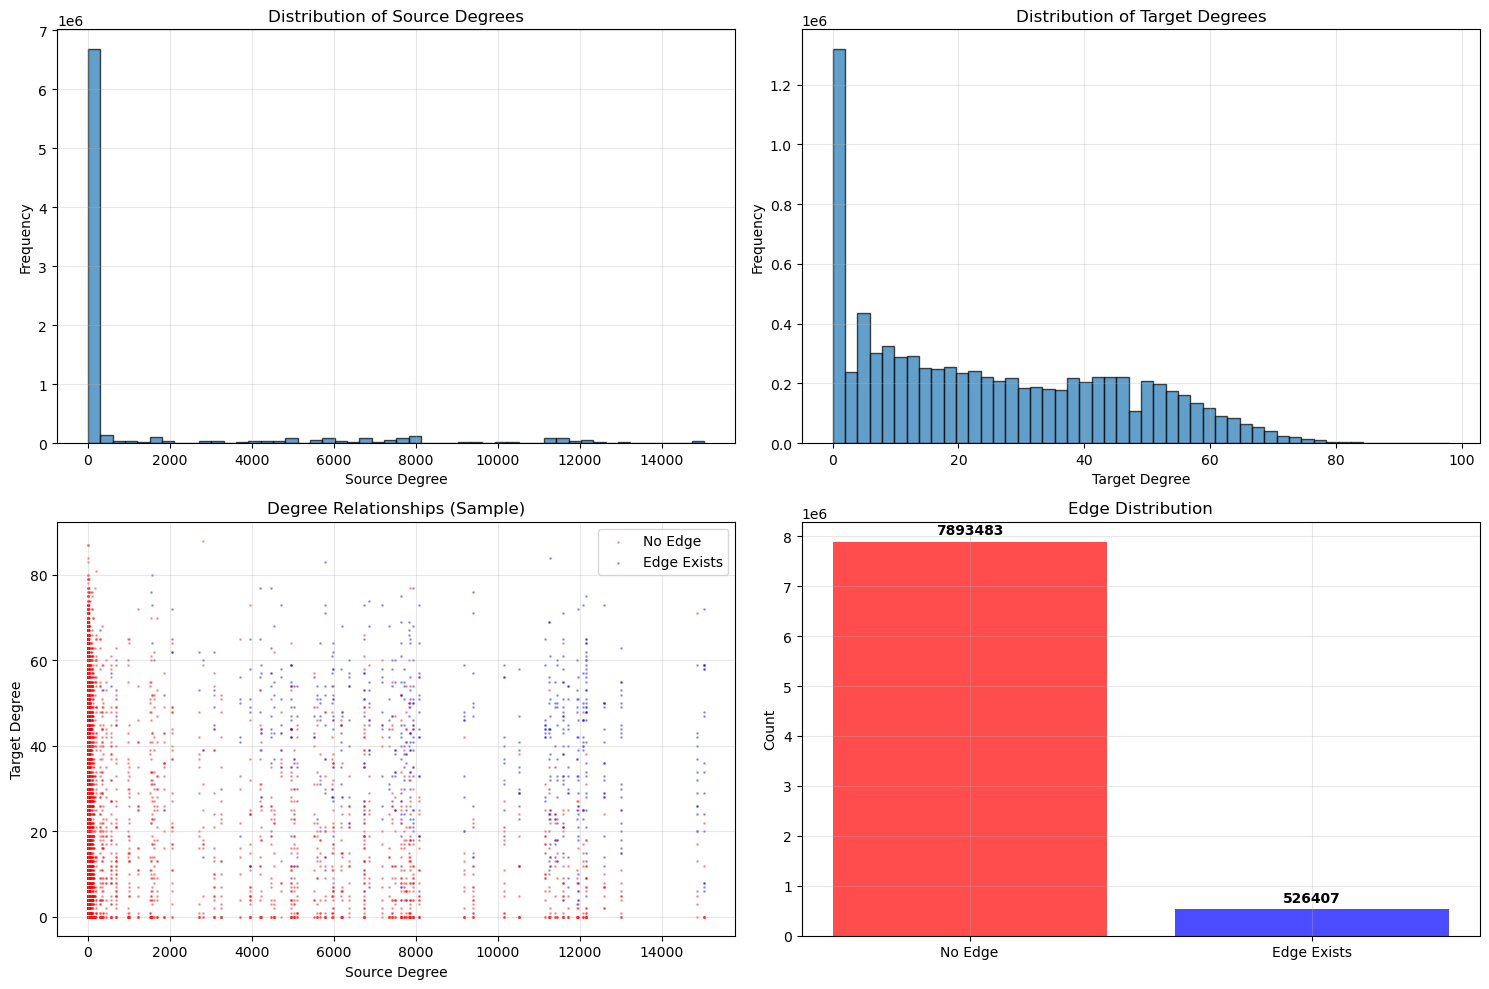

Data distribution visualized and saved.


In [4]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Source degree distribution
axes[0, 0].hist(features[:, 0], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Source Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Source Degrees')
axes[0, 0].grid(True, alpha=0.3)

# Target degree distribution
axes[0, 1].hist(features[:, 1], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Target Degree')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Target Degrees')
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot of degrees (colored by edge existence)
positive_mask = labels == 1
negative_mask = labels == 0

# Sample for visualization (too many points otherwise)
n_sample = min(10000, len(features))
sample_idx = np.random.choice(len(features), n_sample, replace=False)

axes[1, 0].scatter(features[sample_idx[negative_mask[sample_idx]], 0], 
                   features[sample_idx[negative_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='No Edge', color='red')
axes[1, 0].scatter(features[sample_idx[positive_mask[sample_idx]], 0], 
                   features[sample_idx[positive_mask[sample_idx]], 1], 
                   alpha=0.3, s=1, label='Edge Exists', color='blue')
axes[1, 0].set_xlabel('Source Degree')
axes[1, 0].set_ylabel('Target Degree')
axes[1, 0].set_title('Degree Relationships (Sample)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Label distribution
label_counts = pd.Series(labels).value_counts().sort_index()
axes[1, 1].bar(['No Edge', 'Edge Exists'], label_counts.values, 
               color=['red', 'blue'], alpha=0.7)
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Edge Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add count labels on bars
for i, count in enumerate(label_counts.values):
    axes[1, 1].text(i, count + len(features) * 0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'data_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Data distribution visualized and saved.")

## 3. Empirical Frequency vs Analytical Comparison

In this section, we compare empirical frequencies with the analytical approximation formula:

$$P_{i,j} = \frac{u_i v_j}{\sqrt{(u_i v_j)^2 + (m - u_i - v_j + 1)^2}}$$

where $u_i$ is source degree, $v_j$ is target degree, and $m$ is total edges.

In [ ]:
# Load and validate analytical approximation
# Use edge-type-specific empirical frequency file
EMPIRICAL_FREQ_FILE = repo_dir / 'results' / 'empirical_edge_frequencies' / f'edge_frequency_by_degree_{EDGE_TYPE}.csv'

print(f"Empirical frequency file: {EMPIRICAL_FREQ_FILE}")
print(f"File exists: {EMPIRICAL_FREQ_FILE.exists()}")

if EMPIRICAL_FREQ_FILE.exists():
    # Create evaluator for analytical validation
    evaluator = ModelEvaluator()
    
    # Load empirical frequency data
    empirical_df = evaluator.load_empirical_frequencies(str(EMPIRICAL_FREQ_FILE))
    
    # Extract degree combinations and frequencies
    source_degrees_empirical = empirical_df['source_degree'].values
    target_degrees_empirical = empirical_df['target_degree'].values
    empirical_frequencies = empirical_df['empirical_frequency'].values
    
    # Get total number of edges from the edge matrix
    total_edges_m = evaluator.get_total_edges_from_file(str(EDGE_FILE_PATH))
    
    # Validate analytical approximation against empirical frequencies
    validation_results = evaluator.validate_analytical_approximation_vs_empirical(
        source_degrees_empirical, target_degrees_empirical, empirical_frequencies, total_edges_m
    )
    
    print("\nAnalytical approximation validation completed!")
    
else:
    print("Empirical frequency file not found. Skipping analytical validation.")
    print("Run the edge frequency analysis first to generate the empirical frequencies.")
    validation_results = None

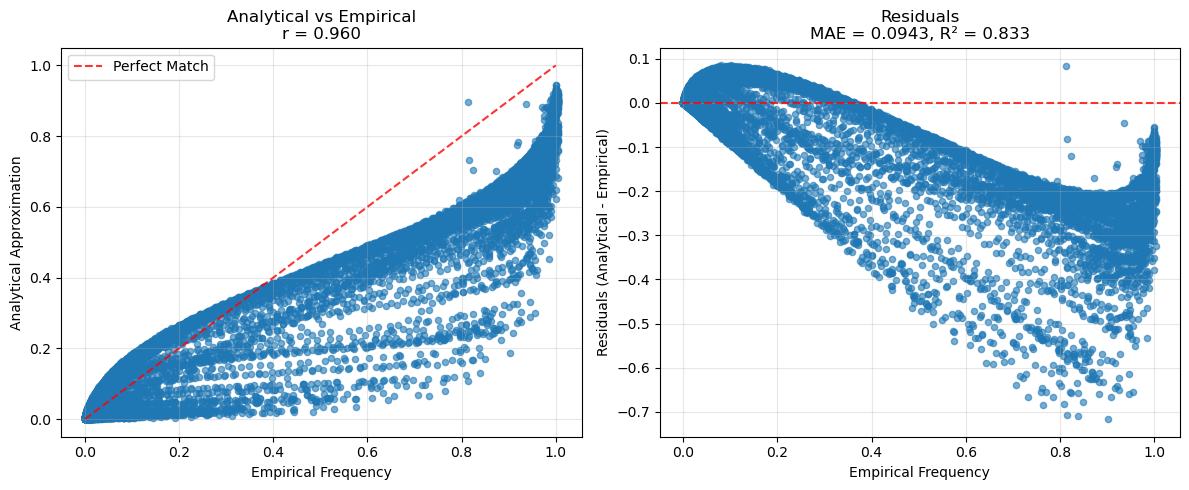

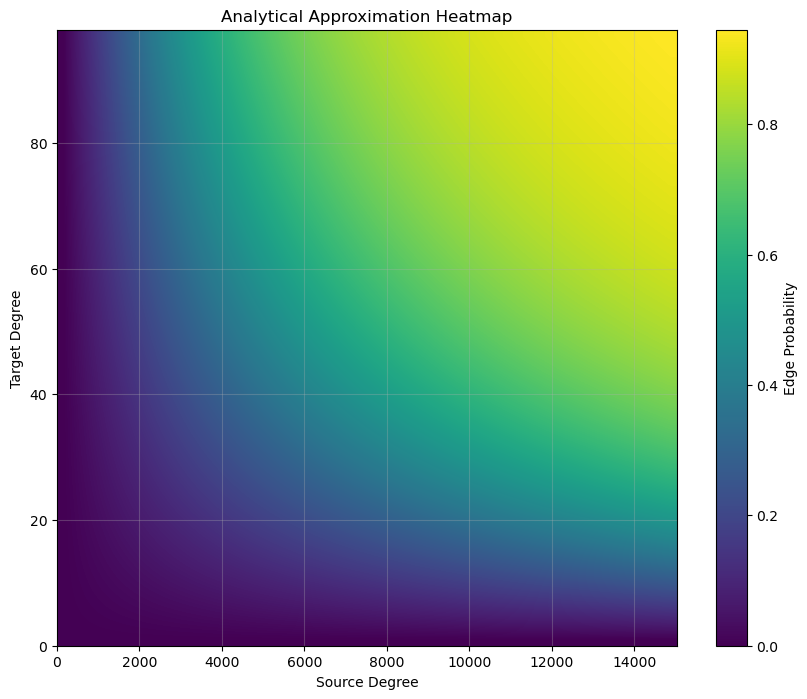

Analytical approximation validation visualizations created!


In [6]:
# Visualize analytical approximation validation (if available)
if validation_results is not None:
    # Create visualizer and plot analytical validation
    visualizer = ModelVisualizer()
    visualizer.plot_analytical_validation(
        validation_results, 
        save_path=results_dir / 'analytical_validation.png'
    )
    
    # Create degree grids for analytical heatmap visualization
    source_degrees_for_heatmap = features[:, 0]
    target_degrees_for_heatmap = features[:, 1]
    
    source_bins_analytical, target_bins_analytical, _ = create_degree_grid(
        source_degrees_for_heatmap, target_degrees_for_heatmap, n_bins=50
    )
    
    # Create analytical approximation heatmap
    visualizer.create_analytical_heatmap(
        source_bins_analytical, target_bins_analytical, validation_results['total_edges_m'],
        save_path=results_dir / 'analytical_heatmap.png'
    )
    
    print("Analytical approximation validation visualizations created!")
else:
    print("Skipping analytical validation visualizations - no validation data available.")

## 4. Model Training with Enhanced Features

**Note**: The Simple Neural Network has been **SIGNIFICANTLY IMPROVED** with:
- **Dynamic input architecture** that adapts to the number of features (18 enhanced features)
- **3-layer architecture** (128→64→32 neurons) for better representation capacity
- **Enhanced Balanced Focal Loss** (50% weighted BCE + 50% focal, α=0.3, γ=2.0) 
- **OneCycleLR scheduler** for superior training dynamics
- **Adaptive sampling** based on edge density for better class balance
- **Domain-specific features** including degree interactions and transformations

In [ ]:
# Create all models with correct input dimension
model_collection = ModelCollection(random_state=RANDOM_STATE)
models = model_collection.create_models(
    use_class_weights=True,
    input_dim=features.shape[1]  # Pass the correct input dimension
)
model_info = model_collection.get_model_info()

print("Models created:")
print("=" * 50)
for name, description in model_info.items():
    print(f"{name}:")
    print(f"  {description}")
    print()

print(f"Neural Network input dimension: {features.shape[1]} features")

In [8]:
# Train all models
trainer = ModelTrainer(random_state=RANDOM_STATE)
training_results = trainer.train_all_models(
    models, features, labels, 
    test_size=TEST_SIZE, 
    val_size=VAL_SIZE
)

print("\nAll models trained successfully!")

TRAINING ALL MODELS
Total samples: 8419890
Training samples: 6735912 (NN uses 6062320 for training, 673592 for validation)
Test samples: 1683978

Training Simple NN...
  Using Focal Loss (alpha=0.25, gamma=2.0)
  pos_weight=14.995 for class imbalance
  Class weights: Positive=7.998, Negative=0.533
  Positive samples: 379013 (6.3%)
  Negative samples: 5683307 (93.7%)
Training Neural Network:
  Training samples: 6062320
  Validation samples: 673592
  Batch size: 4096
  Max epochs: 60
  Epoch 10/60: Train Loss: 0.0073, Val Loss: 0.0071, Val Acc: 0.9631
  Early stopping at epoch 13
  Training completed in 456.76 seconds
  Best validation loss: 0.0071

Training Random Forest...
Training Random Forest:
  Training samples: 6735912
  Training completed in 27.03 seconds

Training Logistic Regression...
Training Logistic Regression:
  Training samples: 6735912
  Training completed in 1.25 seconds

Training Polynomial Logistic Regression...
Training Polynomial Logistic Regression:
  Training samp

## 5. Model Evaluation Statistics and Evaluation Visualizations

In [9]:
# Evaluate all models
evaluator = ModelEvaluator()
X_test = training_results['data_splits']['X_test']
y_test = training_results['data_splits']['y_test']

evaluation_results = evaluator.evaluate_all_models(training_results, X_test, y_test)

print("Model evaluation completed!")

EVALUATING ALL MODELS
Test samples: 1683978
Positive samples: 105281.0 (0.063)

Evaluating Simple NN...
  AUC: 0.9876
  Accuracy: 0.9645
  F1 Score: 0.6365
  RMSE: 0.1603
  Correlation: 0.7722

Evaluating Random Forest...
  AUC: 0.9877
  Accuracy: 0.9704
  F1 Score: 0.7564
  RMSE: 0.1444
  Correlation: 0.8025

Evaluating Logistic Regression...
  AUC: 0.9772
  Accuracy: 0.9673
  F1 Score: 0.7106
  RMSE: 0.1558
  Correlation: 0.7654

Evaluating Polynomial Logistic Regression...
  AUC: 0.9842
  Accuracy: 0.9694
  F1 Score: 0.7437
  RMSE: 0.1479
  Correlation: 0.7918

Model evaluation completed!


In [10]:
# Print detailed evaluation results
evaluator.print_detailed_results(evaluation_results)


DETAILED EVALUATION RESULTS

SIMPLE NN:
--------------------------------------------------
Test Samples: 1683978
Positive Samples: 105281.0 (6.3%)

Classification Metrics:
  AUC-ROC: 0.9876
  Accuracy: 0.9645
  Precision: 0.8847
  Recall/Sensitivity: 0.4971
  Specificity: 0.9957
  F1 Score: 0.6365
  Average Precision: 0.8425

Confusion Matrix:
  True Positives: 52334
  False Positives: 6823
  True Negatives: 1571874
  False Negatives: 52947

Regression Metrics:
  RMSE: 0.1603
  MAE: 0.0723
  R²: 0.5613
  Correlation: 0.7722

RANDOM FOREST:
--------------------------------------------------
Test Samples: 1683978
Positive Samples: 105281.0 (6.3%)

Classification Metrics:
  AUC-ROC: 0.9877
  Accuracy: 0.9704
  Precision: 0.7776
  Recall/Sensitivity: 0.7364
  Specificity: 0.9860
  F1 Score: 0.7564
  Average Precision: 0.8424

Confusion Matrix:
  True Positives: 77524
  False Positives: 22167
  True Negatives: 1556530
  False Negatives: 27757

Regression Metrics:
  RMSE: 0.1444
  MAE: 0.04

In [11]:
# Create and display comparison table
comparison_df = evaluator.create_comparison_dataframe(evaluation_results)
print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Save comparison table
comparison_df.to_csv(results_dir / 'model_comparison.csv', index=False)
print(f"\nComparison table saved to: {results_dir / 'model_comparison.csv'}")

Model Performance Comparison:
                         Model    AUC  Accuracy  Precision  Recall  F1 Score  Average Precision   RMSE    MAE     R²  Correlation
                 Random Forest 0.9877    0.9704     0.7776  0.7364    0.7564             0.8424 0.1444 0.0418 0.6441       0.8025
                     Simple NN 0.9876    0.9645     0.8847  0.4971    0.6365             0.8425 0.1603 0.0723 0.5613       0.7722
Polynomial Logistic Regression 0.9842    0.9694     0.7805  0.7102    0.7437             0.8289 0.1479 0.0427 0.6268       0.7918
           Logistic Regression 0.9772    0.9673     0.7942  0.6430    0.7106             0.8003 0.1558 0.0477 0.5858       0.7654

Comparison table saved to: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/model_comparison/model_comparison.csv


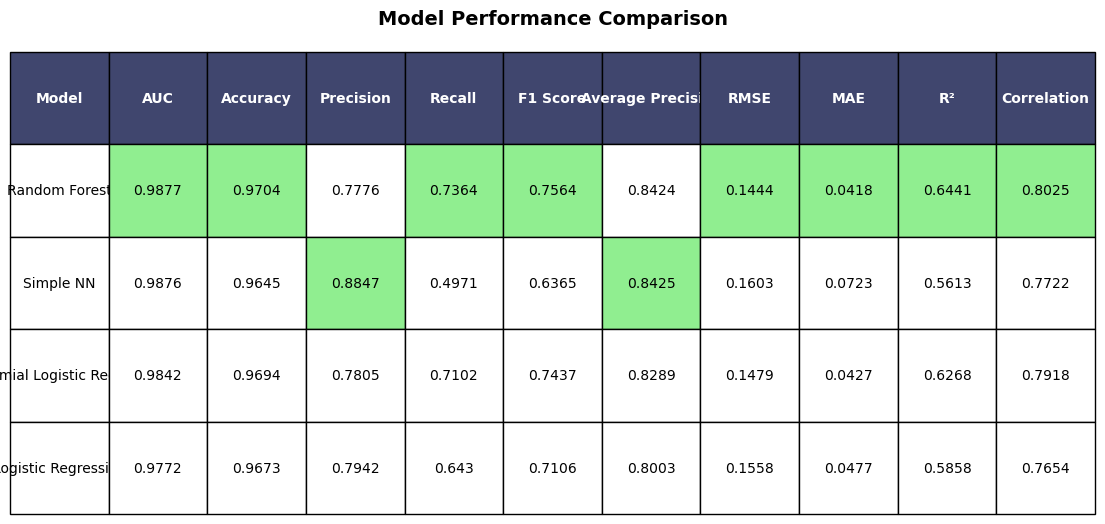

Creating ROC curves...


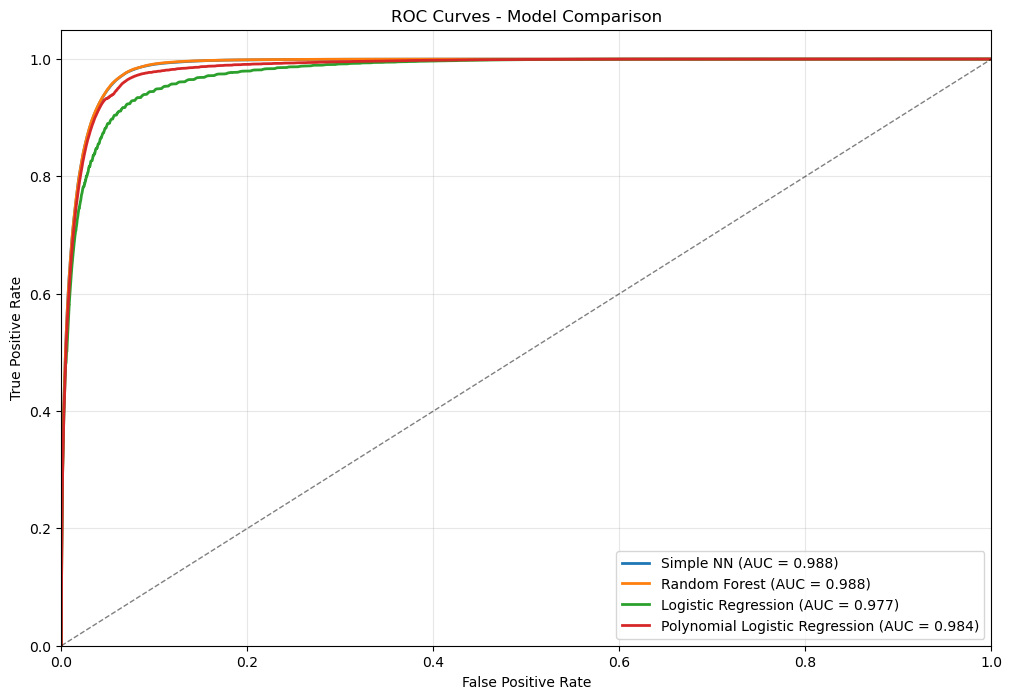

Creating Precision-Recall curves...


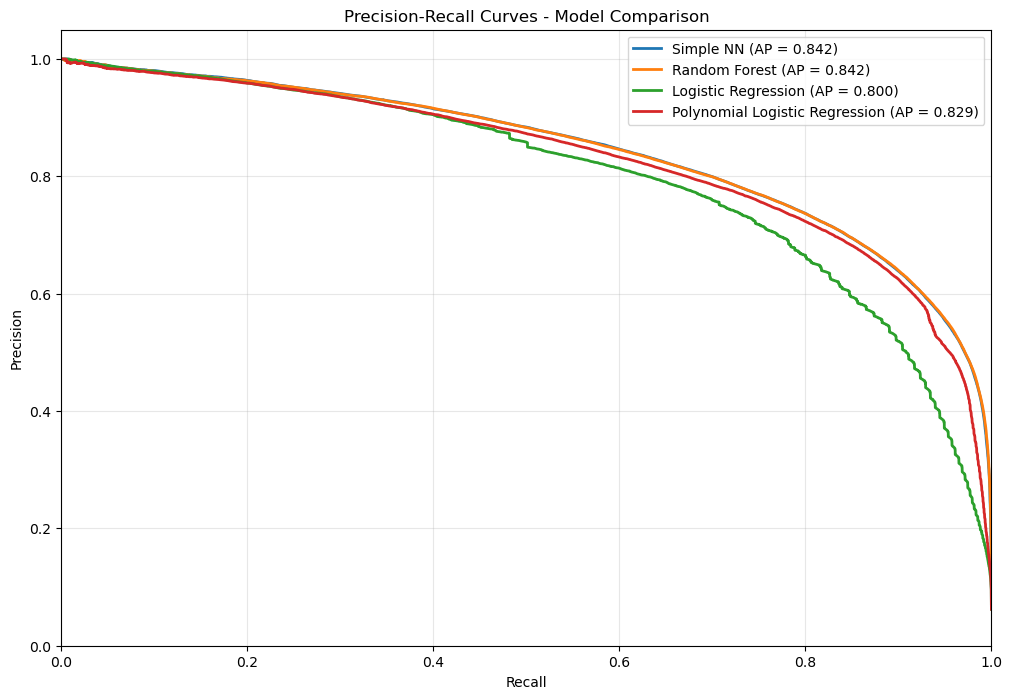

Creating performance comparison...


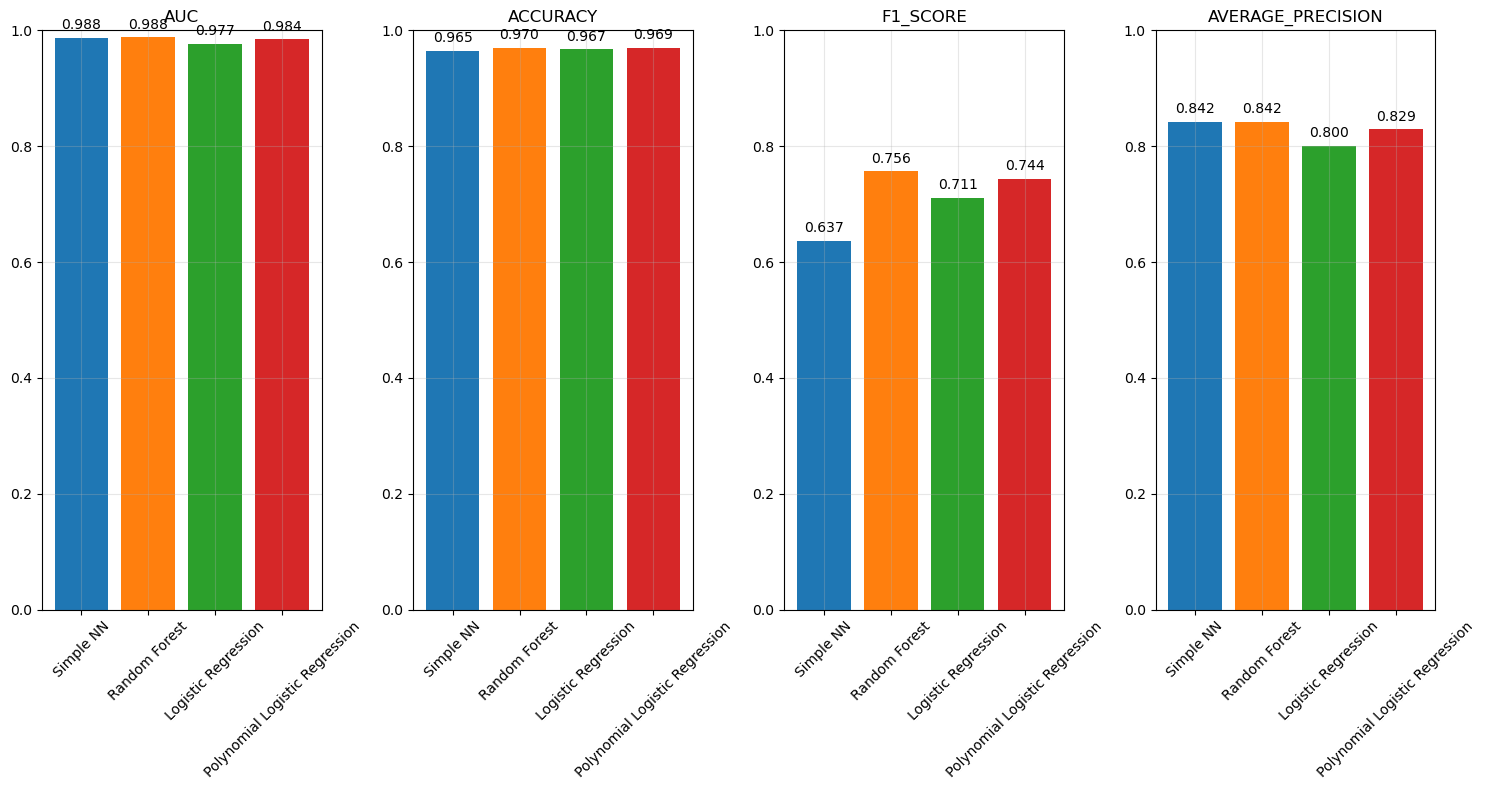

In [12]:
# Create visualizer and evaluation visualizations
visualizer = ModelVisualizer()

# Visual comparison table
create_comparison_table_plot(comparison_df, save_path=results_dir / 'comparison_table.png')

# Plot ROC curves
print("Creating ROC curves...")
visualizer.plot_roc_curves(evaluation_results, save_path=results_dir / 'roc_curves.png')

# Plot Precision-Recall curves
print("Creating Precision-Recall curves...")
visualizer.plot_precision_recall_curves(evaluation_results, save_path=results_dir / 'precision_recall_curves.png')

# Plot performance comparison
print("Creating performance comparison...")
visualizer.plot_performance_comparison(evaluation_results, save_path=results_dir / 'performance_comparison.png')

In [13]:
# Identify best models for each metric
best_models = get_best_models(evaluation_results)

print("Best Models by Metric:")
print("=" * 30)
for metric, model_name in best_models.items():
    print(f"{metric.upper():20}: {model_name}")

Best Models by Metric:
AUC                 : Random Forest
ACCURACY            : Random Forest
F1_SCORE            : Random Forest
AVERAGE_PRECISION   : Simple NN
RMSE                : Random Forest
CORRELATION         : Random Forest


## 6. Model Edge Probability Heatmaps

In [ ]:
# Create degree grids for heatmap visualization with enhanced features
source_degrees = features[:, 0]
target_degrees = features[:, 1]

# Load edge matrix for enhanced feature computation
edge_matrix = sp.load_npz(str(EDGE_FILE_PATH))
print(f"Loaded edge matrix: {edge_matrix.shape}")

# Use enhanced features if we trained with them
use_enhanced_features = features.shape[1] > 2
print(f"Using enhanced features for heatmaps: {use_enhanced_features}")

source_bins, target_bins, grid_features = create_degree_grid(
    source_degrees, target_degrees, n_bins=50,
    enhanced_features=use_enhanced_features,
    edge_matrix=edge_matrix if use_enhanced_features else None
)

print(f"Created degree grid for visualization:")
print(f"  Source degree range: {source_bins.min():.0f} - {source_bins.max():.0f}")
print(f"  Target degree range: {target_bins.min():.0f} - {target_bins.max():.0f}")
print(f"  Grid size: {len(source_bins)} x {len(target_bins)} = {len(grid_features)} points")
print(f"  Grid features shape: {grid_features.shape}")
if use_enhanced_features:
    print(f"  Enhanced features: {grid_features.shape[1]} features per grid point")

In [ ]:
# Create individual heatmaps for each model
print("Creating individual prediction heatmaps...")
visualizer.create_all_prediction_heatmaps(
    training_results, source_bins, target_bins, 
    save_dir=str(results_dir),
    grid_features=grid_features  # Pass the enhanced features we created
)

## 7. Model Predictions vs Analytical

In [16]:
# Compare all model predictions with analytical approximation
analytical_comparison = evaluator.compare_models_vs_analytical_approximation(
    evaluation_results, training_results, X_test, str(EDGE_FILE_PATH)
)

# Print summary of analytical comparison
evaluator.print_analytical_comparison_summary(analytical_comparison)

# Create comparison dataframe
analytical_df = evaluator.create_analytical_comparison_dataframe(analytical_comparison)
print("\nModel Predictions vs Analytical Approximation:")
print("=" * 80)
print(analytical_df.to_string(index=False, float_format='%.6f'))

# Save analytical comparison results
analytical_df.to_csv(results_dir / 'models_vs_analytical_comparison.csv', index=False)
print(f"\nAnalytical comparison saved to: {results_dir / 'models_vs_analytical_comparison.csv'}")

Loaded edge matrix from /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/000.hetmat/edges/AeG.sparse.npz
  Shape: (402, 20945)
  Total edges: 526407

COMPARING MODEL PREDICTIONS WITH ANALYTICAL APPROXIMATION
Total edges (m): 526407
Test samples: 1683978

Comparing Simple NN with analytical approximation...
  MAE vs Analytical: 0.025471
  RMSE vs Analytical: 0.037922
  R² vs Analytical: 0.935246
  Correlation vs Analytical: 0.976975

Comparing Random Forest with analytical approximation...
  MAE vs Analytical: 0.017703
  RMSE vs Analytical: 0.055130
  R² vs Analytical: 0.863145
  Correlation vs Analytical: 0.984146

Comparing Logistic Regression with analytical approximation...
  MAE vs Analytical: 0.032255
  RMSE vs Analytical: 0.077787
  R² vs Analytical: 0.727539
  Correlation vs Analytical: 0.919823

Comparing Polynomial Logistic Regression with analytical approximation...
  MAE vs Analytical: 0

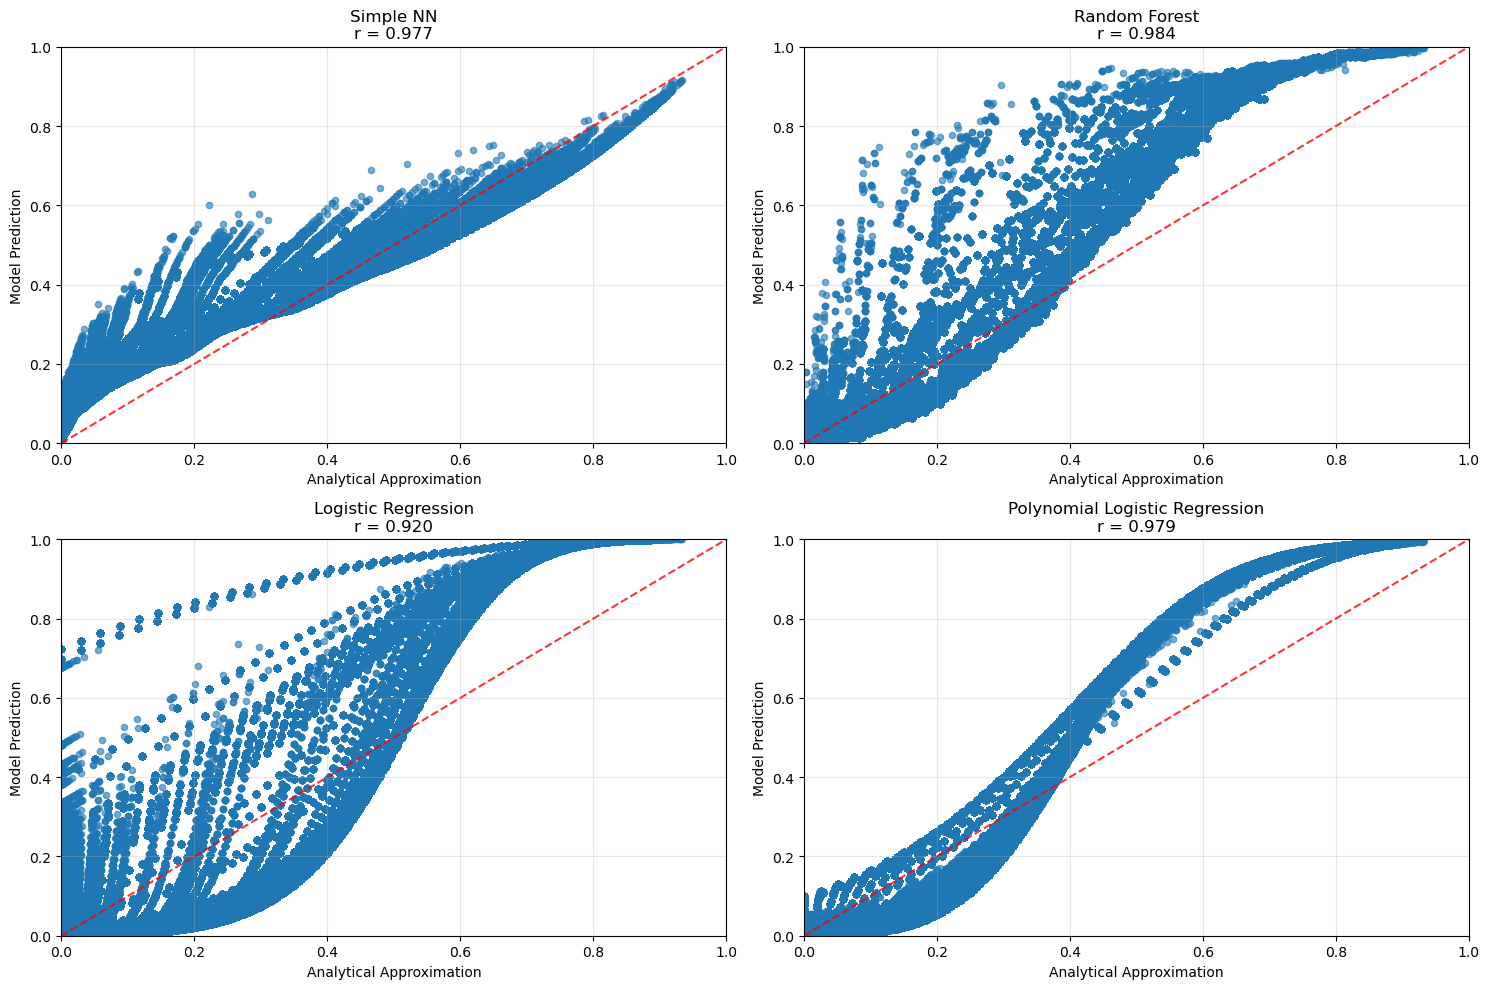

Model predictions vs analytical approximation plots created!


In [17]:
# Visualize model predictions vs analytical approximation
visualizer.plot_models_vs_analytical_comparison(
    analytical_comparison,
    save_path=results_dir / 'models_vs_analytical_scatter.png'
)

print("Model predictions vs analytical approximation plots created!")

## 8. Model Predictions vs Empirical

In [18]:
# Test Predictions vs Empirical Frequencies Comparison
if EMPIRICAL_FREQ_FILE.exists():
    # Compare test predictions with empirical frequencies for the same degree combinations
    test_empirical_comparison = evaluator.compare_test_predictions_with_empirical(
        evaluation_results, training_results, X_test, str(EMPIRICAL_FREQ_FILE)
    )
    
    # Print summary
    evaluator.print_test_empirical_comparison_summary(test_empirical_comparison)
    
    # Create comparison dataframe
    test_empirical_df = evaluator.create_test_empirical_comparison_dataframe(test_empirical_comparison)
    print("\nTest Predictions vs Empirical Frequencies Comparison:")
    print("=" * 80)
    print(test_empirical_df.to_string(index=False, float_format='%.6f'))
    
    # Save comparison results
    test_empirical_df.to_csv(results_dir / 'test_vs_empirical_comparison.csv', index=False)
    print(f"\nTest vs empirical comparison saved to: {results_dir / 'test_vs_empirical_comparison.csv'}")
    
else:
    print("Empirical frequency file not found. Skipping empirical comparison.")
    print("Run the edge frequency analysis first to generate the empirical frequencies.")
    test_empirical_comparison = None
    test_empirical_df = None

Loaded empirical frequencies from: /Users/gillenlu/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/results/edge_frequency_by_degree.csv
  Records: 13167
  Source degree range: 1 - 15036
  Target degree range: 1 - 98
  Frequency range: 0.000001 - 1.004902

COMPARING TEST PREDICTIONS WITH EMPIRICAL FREQUENCIES

Comparing Simple NN test predictions with empirical frequencies...
  Matched degree combinations: 843983/1683978 (50.1%)
  MAE vs Empirical: 0.063113
  RMSE vs Empirical: 0.097544
  R² vs Empirical: 0.859618
  Correlation vs Empirical: 0.962703

Comparing Random Forest test predictions with empirical frequencies...
  Matched degree combinations: 843983/1683978 (50.1%)
  MAE vs Empirical: 0.003270
  RMSE vs Empirical: 0.007794
  R² vs Empirical: 0.999104
  Correlation vs Empirical: 0.999559

Comparing Logistic Regression test predictions with empirical frequencies...
  Matched degree combinations: 843983/1683978 (50.1%)
  MAE 

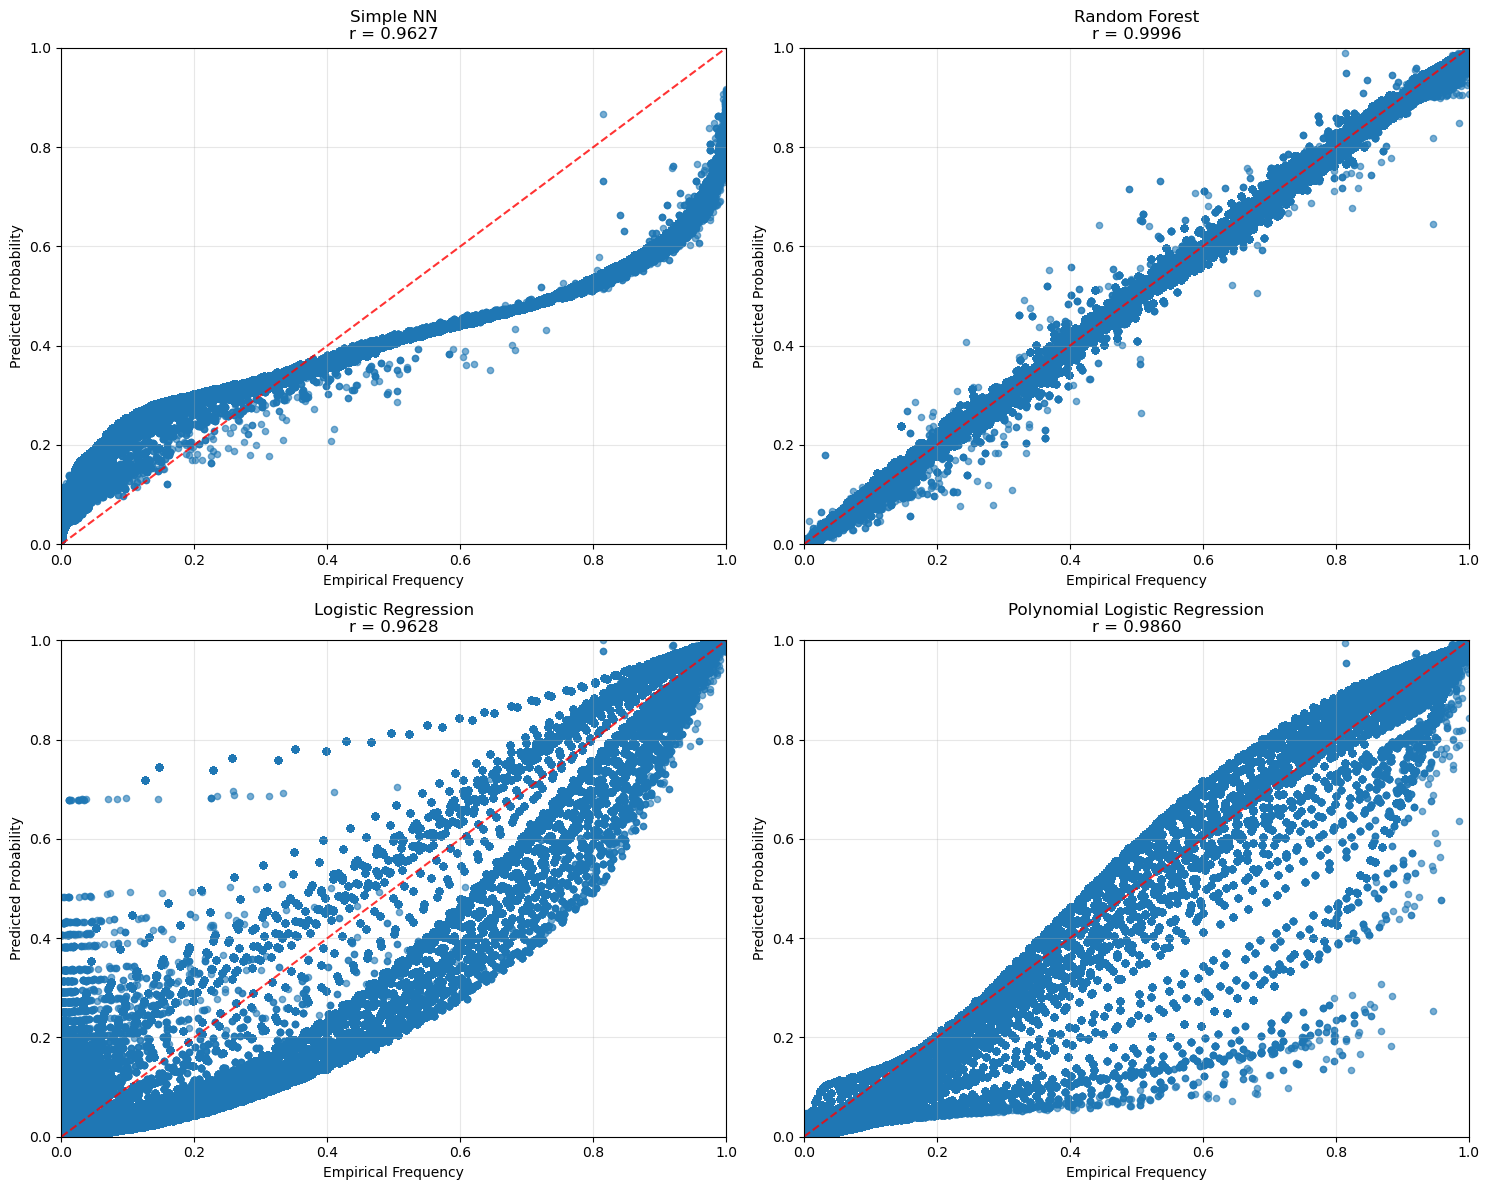

Test vs empirical scatter plots created!


In [19]:
# Create scatter plot comparing predictions vs empirical frequencies
if test_empirical_comparison is not None:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (model_name, results) in enumerate(test_empirical_comparison.items()):
        if i >= 4:  # Only plot first 4 models
            break
            
        predictions = results['matched_predictions']
        empirical = results['matched_empirical']
        correlation = results['correlation_vs_empirical']
        
        axes[i].scatter(empirical, predictions, alpha=0.6, s=20)
        axes[i].plot([0, 1], [0, 1], 'r--', alpha=0.8)  # Perfect correlation line
        axes[i].set_xlabel('Empirical Frequency')
        axes[i].set_ylabel('Predicted Probability')
        axes[i].set_title(f'{model_name}\nr = {correlation:.4f}')
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'test_vs_empirical_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Test vs empirical scatter plots created!")

## 9. Enhanced Scatter Plots Colored by Node Features

This section implements scatter plots colored by:
- Source degree
- Target degree 
- Source × Target degree

These visualizations help understand how model predictions relate to different node characteristics.

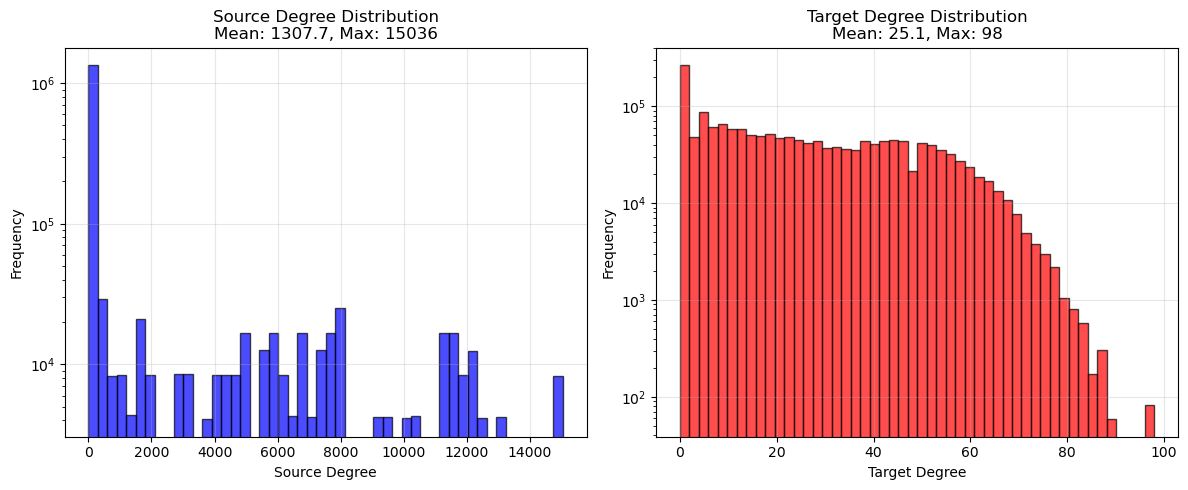

Test set degree statistics:
  Source degrees: 0 - 15036 (mean: 1307.7)
  Target degrees: 0 - 98 (mean: 25.1)


In [20]:
# Extract degree information for coloring
test_source_degrees = X_test[:, 0]
test_target_degrees = X_test[:, 1]

# Plot degree distributions for context
plot_degree_distribution_comparison(
    test_source_degrees, test_target_degrees,
    save_path=results_dir / 'test_degree_distributions.png'
)

print(f"Test set degree statistics:")
print(f"  Source degrees: {test_source_degrees.min():.0f} - {test_source_degrees.max():.0f} (mean: {test_source_degrees.mean():.1f})")
print(f"  Target degrees: {test_target_degrees.min():.0f} - {test_target_degrees.max():.0f} (mean: {test_target_degrees.mean():.1f})")

In [21]:
# Create model predictions dictionary for coloring
# Import prediction function
from model_training import predict_with_model

model_predictions_dict = {}
for model_name, model_result in training_results.items():
    if model_name == 'data_splits':
        continue
    
    model = model_result['model']
    scaler = model_result['training_result'].get('scaler')
    predictions = predict_with_model(model, X_test, model_name, scaler)
    model_predictions_dict[model_name] = predictions

print(f"Generated predictions for {len(model_predictions_dict)} models")

# Use empirical frequencies if available, otherwise use y_test as ground truth
if test_empirical_comparison is not None:
    print("Using properly matched empirical data from test_empirical_comparison")
    
    # Get the matched data from the first model (they should all have the same empirical values)
    first_model_results = list(test_empirical_comparison.values())[0]
    reference_values = first_model_results['matched_empirical']
    
    # Use the matched predictions from each model instead of truncating
    model_predictions_truncated = {}
    for model_name in model_predictions_dict.keys():
        if model_name in test_empirical_comparison:
            model_predictions_truncated[model_name] = test_empirical_comparison[model_name]['matched_predictions']
        else:
            # Fallback if model not found
            model_predictions_truncated[model_name] = model_predictions_dict[model_name][:len(reference_values)]
    
    # CRITICAL FIX: Reconstruct the actual degree combinations that were matched
    # Load the empirical frequency data to recreate the matching process
    empirical_df = pd.read_csv(str(EMPIRICAL_FREQ_FILE))
    
    # Create the same lookup dictionary used in model_evaluation.py
    # FIX: Use 'frequency' column name, not 'empirical_frequency'
    empirical_lookup = {}
    for _, row in empirical_df.iterrows():
        key = (int(row['source_degree']), int(row['target_degree']))
        empirical_lookup[key] = row['frequency']  # FIXED: Use correct column name
    
    # Recreate the matching process to get the exact degree combinations
    matched_source_degrees = []
    matched_target_degrees = []
    matched_empirical_check = []
    
    for i, (source_deg, target_deg) in enumerate(X_test):
        key = (int(source_deg), int(target_deg))
        if key in empirical_lookup:
            matched_source_degrees.append(source_deg)
            matched_target_degrees.append(target_deg)
            matched_empirical_check.append(empirical_lookup[key])
    
    # Convert to numpy arrays
    source_degrees_for_coloring = np.array(matched_source_degrees)
    target_degrees_for_coloring = np.array(matched_target_degrees)
    matched_empirical_check = np.array(matched_empirical_check)
    
    # Verify our reconstruction matches the empirical comparison
    if len(source_degrees_for_coloring) == len(reference_values):
        if np.allclose(matched_empirical_check, reference_values, rtol=1e-10):
            print("✓ Perfect match: Reconstructed degree combinations match empirical data exactly!")
        else:
            print("⚠ Warning: Reconstructed empirical values don't match perfectly")
            print(f"  Max difference: {np.max(np.abs(matched_empirical_check - reference_values))}")
    else:
        print(f"⚠ Length mismatch: {len(source_degrees_for_coloring)} reconstructed vs {len(reference_values)} reference")
    
    reference_label = "Empirical Frequency"
    print(f"Using empirical frequencies as reference ({len(reference_values)} points)")
    print(f"Degree ranges - Source: {source_degrees_for_coloring.min():.0f}-{source_degrees_for_coloring.max():.0f}, Target: {target_degrees_for_coloring.min():.0f}-{target_degrees_for_coloring.max():.0f}")
    print(f"Degree product range: {(source_degrees_for_coloring * target_degrees_for_coloring).min():.0f}-{(source_degrees_for_coloring * target_degrees_for_coloring).max():.0f}")
    
else:
    reference_values = y_test
    model_predictions_truncated = model_predictions_dict
    source_degrees_for_coloring = test_source_degrees
    target_degrees_for_coloring = test_target_degrees
    reference_label = "Ground Truth"
    print(f"Using test labels as reference ({len(reference_values)} points)")

Generated predictions for 4 models
Using properly matched empirical data from test_empirical_comparison
✓ Perfect match: Reconstructed degree combinations match empirical data exactly!
Using empirical frequencies as reference (843983 points)
Degree ranges - Source: 1-15036, Target: 1-98
Degree product range: 4-1323168


Creating scatter plots colored by source degree...


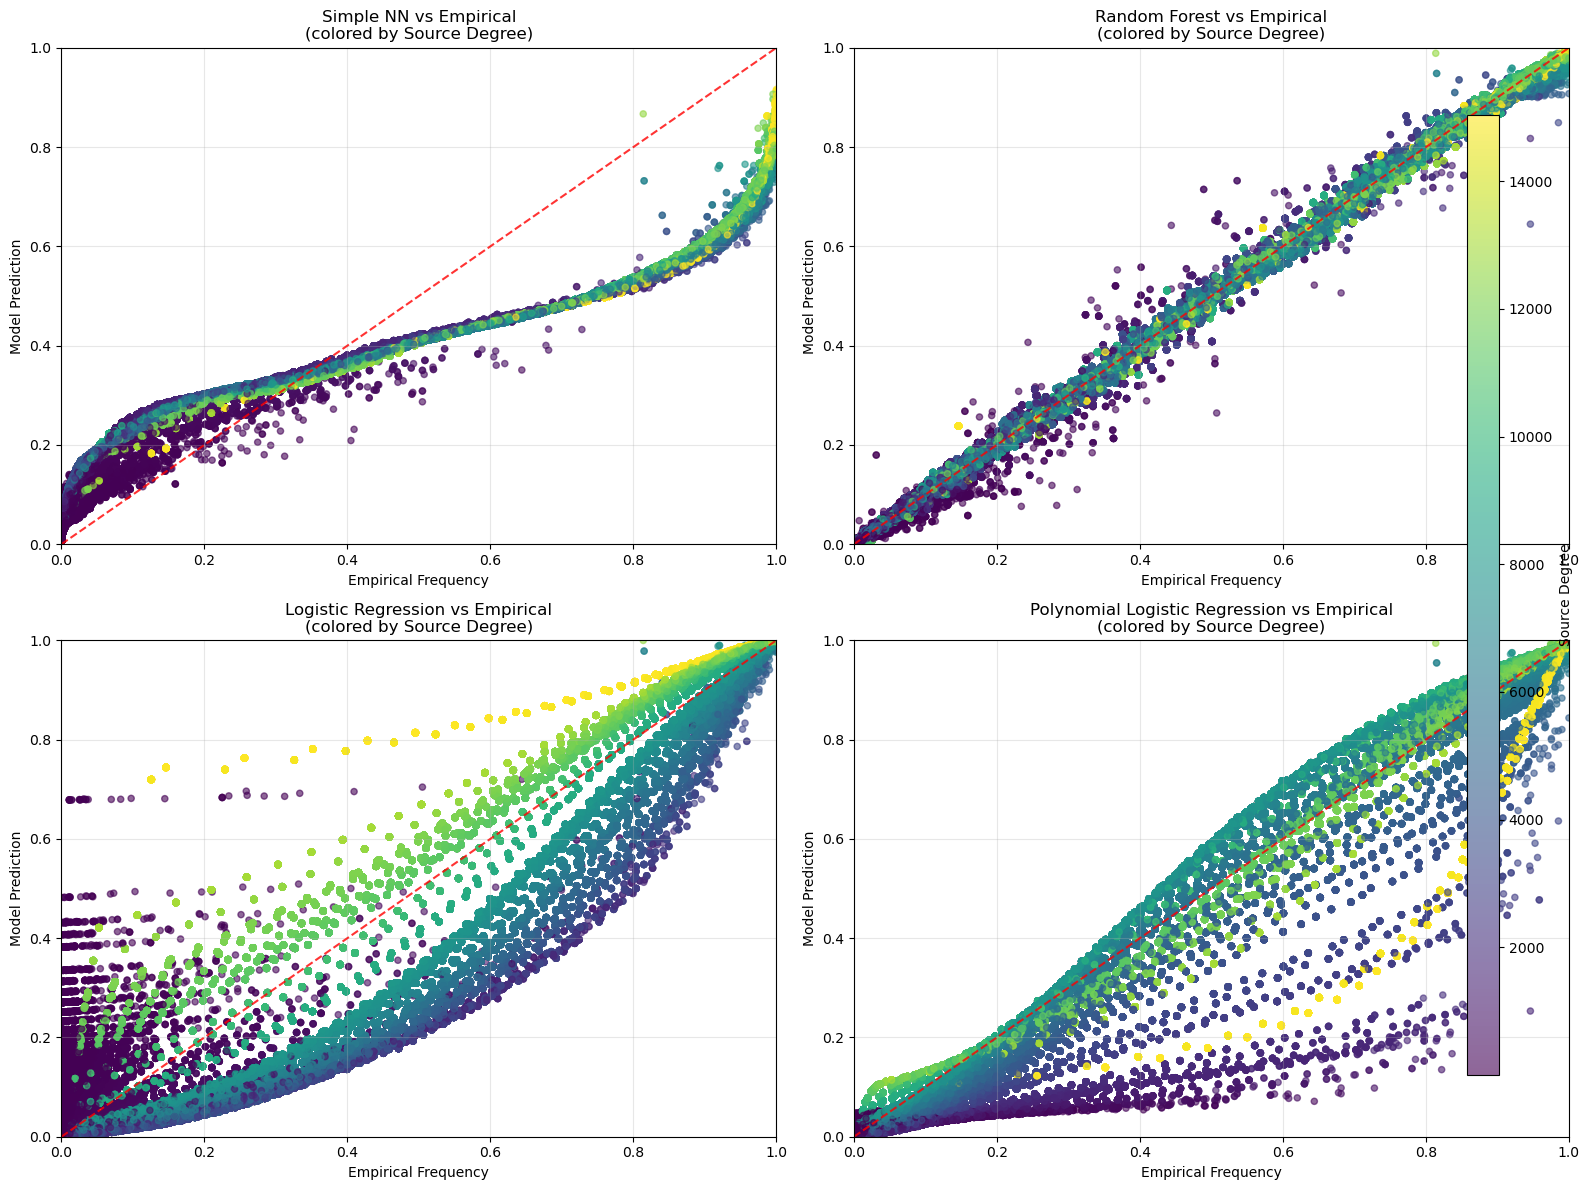

Scatter plots colored by source degree created!


In [22]:
# Create scatter plots colored by source degree
print("Creating scatter plots colored by source degree...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='source_degree',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_source_degree.png'
)

print("Scatter plots colored by source degree created!")

Creating scatter plots colored by target degree...


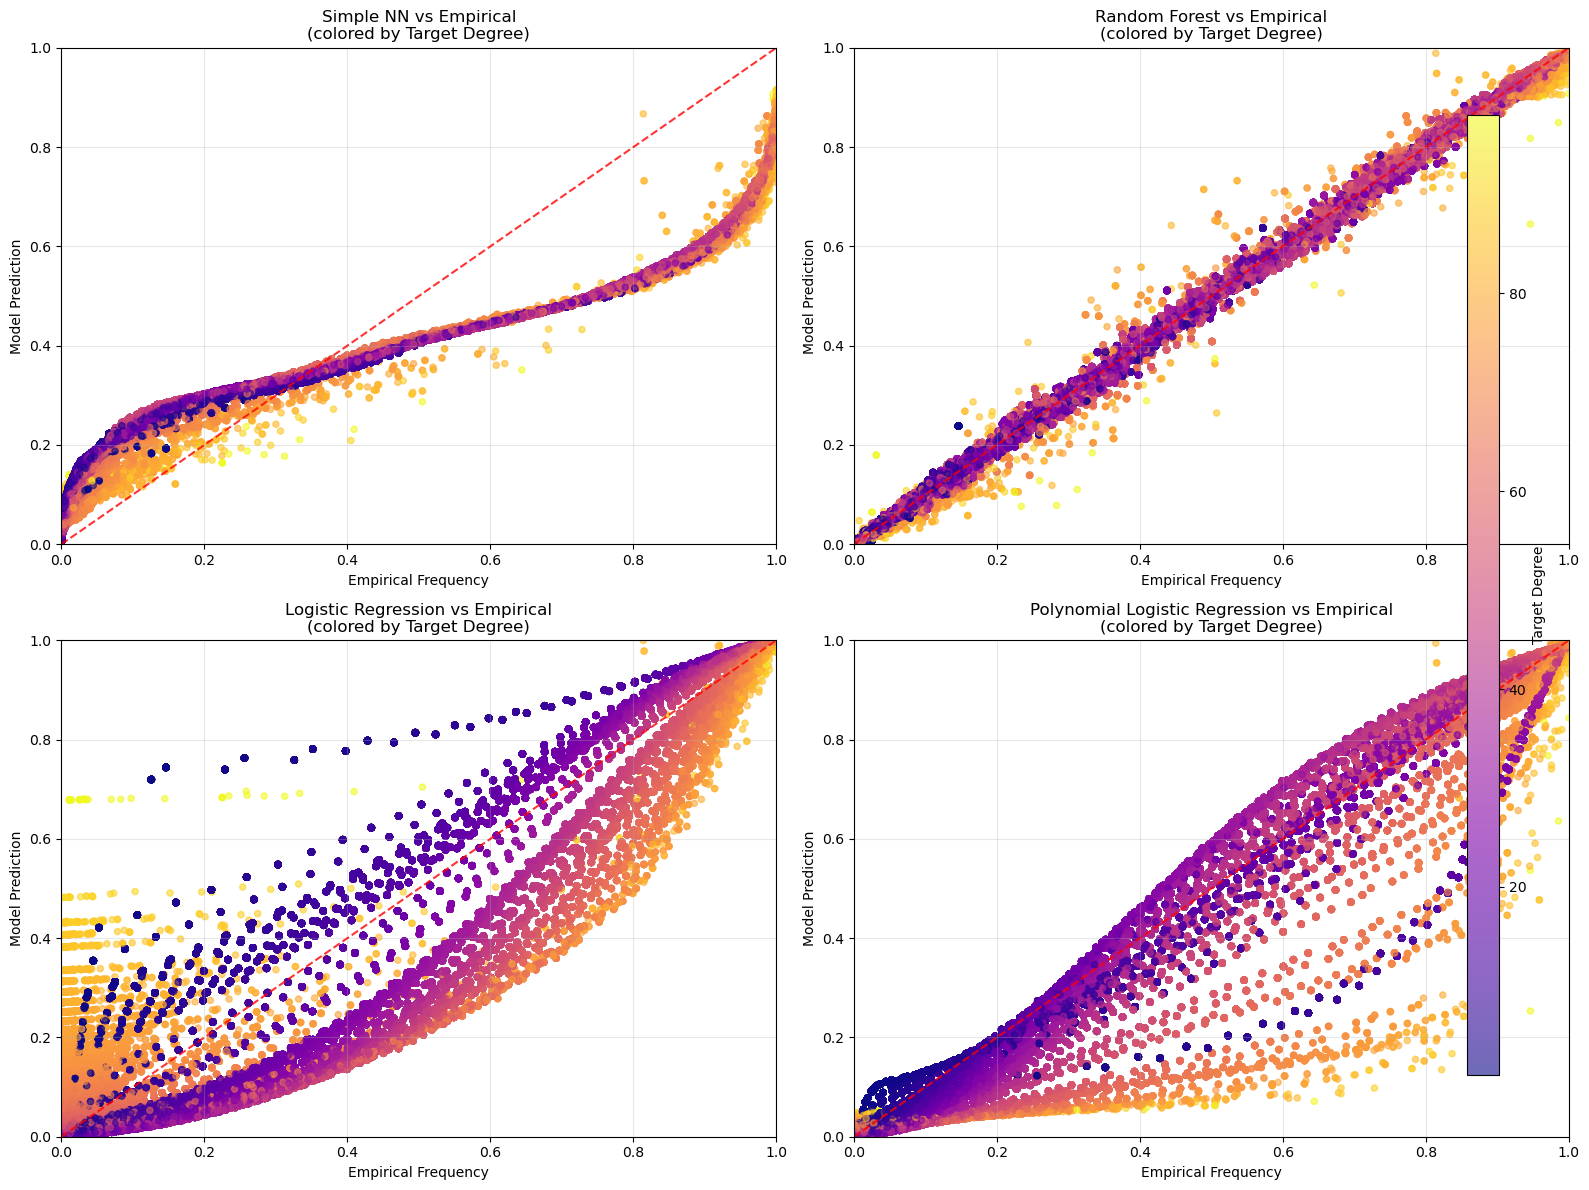

Scatter plots colored by target degree created!


In [23]:
# Create scatter plots colored by target degree
print("Creating scatter plots colored by target degree...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='target_degree',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_target_degree.png'
)

print("Scatter plots colored by target degree created!")

Creating scatter plots colored by degree product...


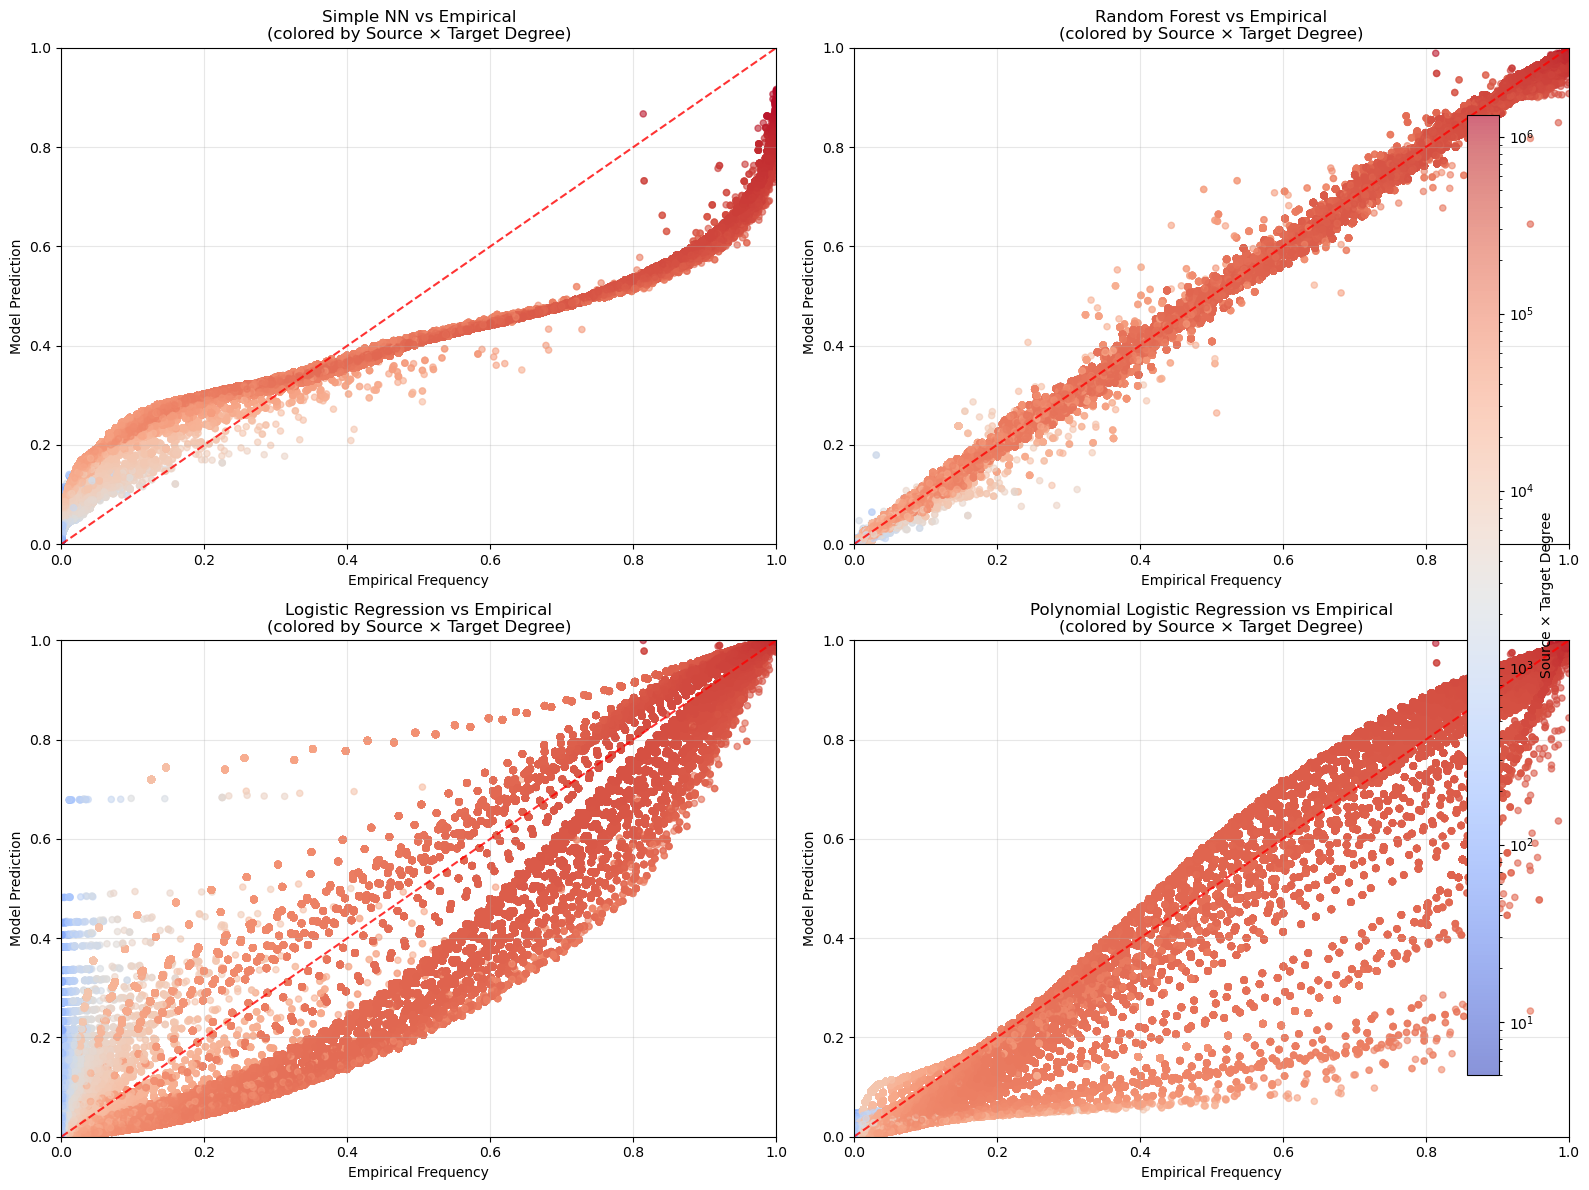

Scatter plots colored by degree product created!


In [24]:
# Create scatter plots colored by source × target degree product
print("Creating scatter plots colored by degree product...")
create_model_comparison_grid_with_coloring(
    model_predictions_truncated, reference_values,
    source_degrees_for_coloring, target_degrees_for_coloring,
    color_by='degree_product',
    figsize=(16, 12),
    save_path=results_dir / 'models_colored_by_degree_product.png'
)

print("Scatter plots colored by degree product created!")

In [ ]:
# Example individual colored scatter plots for the best model
# Use the model with highest correlation to empirical frequencies
if test_empirical_comparison is not None:
    best_model_name = test_empirical_df.iloc[0]['Model']  # Best empirical correlation
    print(f"Using model with best empirical correlation: {best_model_name}")
else:
    best_model_name = comparison_df.iloc[0]['Model']  # Fallback to best AUC
    print(f"Using model with best AUC (no empirical data): {best_model_name}")

best_model_predictions = model_predictions_truncated[best_model_name]

print(f"Creating detailed colored scatter plots for best model: {best_model_name}")

# Source degree coloring
plot_colored_scatter_by_source_degree(
    reference_values, best_model_predictions, source_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Source Degree)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_source_degree.png'
)

# Target degree coloring
plot_colored_scatter_by_target_degree(
    reference_values, best_model_predictions, target_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Target Degree)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_target_degree.png'
)

# Degree product coloring
plot_colored_scatter_by_degree_product(
    reference_values, best_model_predictions, 
    source_degrees_for_coloring, target_degrees_for_coloring,
    title=f"{best_model_name} Predictions vs {reference_label} (Colored by Degree Product)",
    xlabel=reference_label, ylabel=f"{best_model_name} Prediction",
    save_path=results_dir / f'{best_model_name.replace(" ", "_")}_colored_by_degree_product.png'
)

print(f"Detailed colored scatter plots for {best_model_name} created!")

## 10. Final Summary

In [26]:
# Comprehensive summary analysis
print("=" * 80)
print("MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge file: {EDGE_FILE_PATH.name}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

for metric in ['Accuracy', 'F1 Score', 'RMSE', 'Correlation']:
    if metric in ['RMSE']:
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
        direction = "(lower is better)"
    else:
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
        direction = "(higher is better)"
    
    best_model = comparison_df.loc[best_idx, 'Model']
    print(f"  Best {metric}: {best_model} ({metric} = {best_value:.4f}) {direction}")

# Add analytical approximation results if available
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    print(f"\nAnalytical Approximation Analysis:")
    best_analytical_corr_model = analytical_df.iloc[0]['Model']
    best_analytical_corr = analytical_df.iloc[0]['Correlation vs Analytical']
    print(f"  Best correlation with analytical: {best_analytical_corr_model} (r = {best_analytical_corr:.6f})")

# Add empirical validation results if available
if validation_results is not None:
    analytical_emp_corr = validation_results['correlation_vs_empirical']
    print(f"  Analytical vs Empirical correlation: {analytical_emp_corr:.6f}")

if test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best correlation with empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")


print(f"\nGenerated Files:")
generated_files = list(results_dir.glob('*'))
for file_path in sorted(generated_files)[-10:]:  # Show last 10 files
    print(f"  - {file_path.name}")
if len(generated_files) > 10:
    print(f"  ... and {len(generated_files) - 10} more files")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)

MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED

Dataset:
  Edge file: AeG.sparse.npz
  Total samples: 8,419,890
  Test samples: 1,683,978
  Positive ratio: 6.3%

Best Performing Models:
  Overall Best (AUC): Random Forest (AUC = 0.9877)
  Best Accuracy: Random Forest (Accuracy = 0.9704) (higher is better)
  Best F1 Score: Random Forest (F1 Score = 0.7564) (higher is better)
  Best RMSE: Random Forest (RMSE = 0.1444) (lower is better)
  Best Correlation: Random Forest (Correlation = 0.8025) (higher is better)

Analytical Approximation Analysis:
  Best correlation with analytical: Random Forest (r = 0.984146)
  Analytical vs Empirical correlation: 0.959711

Test Predictions vs Empirical Frequencies:
  Best correlation with empirical: Random Forest (r = 0.999559)

Generated Files:
  - notebook4_exact_rf_scatter_plots
  - performance_comparison.png
  - precision_recall_curves.png
  - real_model_predictions_scatter_plots
  - roc_curves.png
  - test_degree_distributions.png


In [ ]:
# Save the comprehensive predictions to CSV files
print("Saving model predictions to files...")

# Save the full predictions dataframe
full_predictions_file = results_dir / f'{EDGE_TYPE}_all_model_predictions.csv'
predictions_df.to_csv(full_predictions_file, index=False)
print(f"✓ Saved full predictions: {full_predictions_file}")
print(f"  File size: {full_predictions_file.stat().st_size / (1024*1024):.1f} MB")

# Also save a compressed version for large files
full_predictions_file_gz = results_dir / f'{EDGE_TYPE}_all_model_predictions.csv.gz'
predictions_df.to_csv(full_predictions_file_gz, index=False, compression='gzip')
print(f"✓ Saved compressed predictions: {full_predictions_file_gz}")
print(f"  File size: {full_predictions_file_gz.stat().st_size / (1024*1024):.1f} MB")

# Save a summary of predictions by degree combinations (aggregated)
print("\\nCreating degree-based prediction summary...")
degree_summary = predictions_df.groupby(['source_degree', 'target_degree']).agg({
    'edge_exists': ['count', 'sum', 'mean'],
    **{f'{model_name.replace(\" \", \"_\").replace(\"(\", \"\").replace(\")\", \"\").lower()}_prediction': ['mean', 'std'] 
       for model_name in all_model_predictions.keys()}
}).round(6)

# Flatten column names
degree_summary.columns = ['_'.join(col).strip() for col in degree_summary.columns.values]
degree_summary = degree_summary.reset_index()

# Save degree summary
degree_summary_file = results_dir / f'{EDGE_TYPE}_predictions_by_degree.csv'
degree_summary.to_csv(degree_summary_file, index=False)
print(f"✓ Saved degree summary: {degree_summary_file}")
print(f"  Rows: {len(degree_summary):,} unique degree combinations")

# Save prediction metadata
metadata = {
    'edge_type': EDGE_TYPE,
    'edge_file': edge_file,
    'total_combinations': len(predictions_df),
    'existing_edges': int(predictions_df['edge_exists'].sum()),
    'edge_density': float(predictions_df['edge_exists'].mean()),
    'source_nodes': int(n_sources),
    'target_nodes': int(n_targets),
    'models': list(all_model_predictions.keys()),
    'prediction_times_seconds': prediction_times,
    'file_sizes_mb': {
        'full_csv': round(full_predictions_file.stat().st_size / (1024*1024), 2),
        'compressed_csv': round(full_predictions_file_gz.stat().st_size / (1024*1024), 2)
    }
}

import json
metadata_file = results_dir / f'{EDGE_TYPE}_predictions_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata: {metadata_file}")

print(f"\\nAll prediction files saved to: {results_dir}")
print("Files generated:")
print(f"  1. {full_predictions_file.name} - Full predictions for all combinations")
print(f"  2. {full_predictions_file_gz.name} - Compressed version")
print(f"  3. {degree_summary_file.name} - Aggregated predictions by degree")
print(f"  4. {metadata_file.name} - Metadata and summary statistics")

In [ ]:
# Create comprehensive predictions dataframe for all source-target combinations
print("Creating comprehensive predictions dataframe...")

# Create base dataframe with source/target information
predictions_df = pd.DataFrame({
    'source_index': source_indices,
    'target_index': target_indices,
    'source_degree': all_features[:, 0],
    'target_degree': all_features[:, 1],
    'degree_product': all_features[:, 0] * all_features[:, 1],
    'edge_exists': [bool(edge_matrix[i, j]) for i, j in zip(source_indices, target_indices)]
})

# Add model predictions as columns
for model_name, predictions in all_model_predictions.items():
    # Clean model name for column naming
    clean_name = model_name.replace(' ', '_').replace('(', '').replace(')', '').lower()
    predictions_df[f'{clean_name}_prediction'] = predictions

print(f"Predictions dataframe shape: {predictions_df.shape}")
print(f"Columns: {list(predictions_df.columns)}")

# Display summary statistics
print("\nDataframe Summary:")
print(f"  Total combinations: {len(predictions_df):,}")
print(f"  Existing edges: {predictions_df['edge_exists'].sum():,} ({predictions_df['edge_exists'].mean():.1%})")
print(f"  Non-existing edges: {(~predictions_df['edge_exists']).sum():,} ({(~predictions_df['edge_exists']).mean():.1%})")
print(f"  Unique source degrees: {predictions_df['source_degree'].nunique()}")
print(f"  Unique target degrees: {predictions_df['target_degree'].nunique()}")

# Show first few rows
print("\nFirst 5 rows:")
print(predictions_df.head())

In [ ]:
# Generate predictions for all models on all source-target combinations
print("Generating model predictions for all source-target combinations...")
print(f"Total combinations to predict: {len(all_features):,}")

all_model_predictions = {}
prediction_times = {}

for model_name, model_result in training_results.items():
    if model_name == 'data_splits':
        continue
    
    print(f"\nGenerating predictions for {model_name}...")
    start_time = time.time()
    
    # Get model and scaler
    model = model_result['model']
    scaler = model_result['training_result'].get('scaler')
    
    # Generate predictions for all combinations
    predictions = predict_with_model(model, all_features, model_name, scaler)
    all_model_predictions[model_name] = predictions
    
    prediction_time = time.time() - start_time
    prediction_times[model_name] = prediction_time
    
    print(f"  Predictions generated in {prediction_time:.2f} seconds")
    print(f"  Prediction range: {predictions.min():.6f} - {predictions.max():.6f}")
    print(f"  Mean prediction: {predictions.mean():.6f}")

print(f"\nAll model predictions generated for {len(all_model_predictions)} models.")

In [ ]:
# Save a summary of predictions by degree combinations (aggregated)
print("\\nCreating degree-based prediction summary...")

# Prepare aggregation dictionary
agg_dict = {
    'edge_exists': ['count', 'sum', 'mean']
}

# Add model prediction columns with proper string handling
for model_name in all_model_predictions.keys():
    clean_name = model_name.replace(" ", "_").replace("(", "").replace(")", "").lower()
    pred_col = f'{clean_name}_prediction'
    agg_dict[pred_col] = ['mean', 'std']

degree_summary = predictions_df.groupby(['source_degree', 'target_degree']).agg(agg_dict).round(6)

# Flatten column names
degree_summary.columns = ['_'.join(col).strip() for col in degree_summary.columns.values]
degree_summary = degree_summary.reset_index()

# Save degree summary
degree_summary_file = results_dir / f'{EDGE_TYPE}_predictions_by_degree.csv'
degree_summary.to_csv(degree_summary_file, index=False)
print(f"✓ Saved degree summary: {degree_summary_file}")
print(f"  Rows: {len(degree_summary):,} unique degree combinations")

# Save prediction metadata
metadata = {
    'edge_type': EDGE_TYPE,
    'edge_file': edge_file,
    'total_combinations': len(predictions_df),
    'existing_edges': int(predictions_df['edge_exists'].sum()),
    'edge_density': float(predictions_df['edge_exists'].mean()),
    'source_nodes': int(n_sources),
    'target_nodes': int(n_targets),
    'models': list(all_model_predictions.keys()),
    'prediction_times_seconds': prediction_times,
    'file_sizes_mb': {
        'full_csv': round(full_predictions_file.stat().st_size / (1024*1024), 2),
        'compressed_csv': round(full_predictions_file_gz.stat().st_size / (1024*1024), 2)
    }
}

import json
metadata_file = results_dir / f'{EDGE_TYPE}_predictions_metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved metadata: {metadata_file}")

print(f"\\nAll prediction files saved to: {results_dir}")
print("Files generated:")
print(f"  1. {full_predictions_file.name} - Full predictions for all combinations")
print(f"  2. {full_predictions_file_gz.name} - Compressed version")
print(f"  3. {degree_summary_file.name} - Aggregated predictions by degree")
print(f"  4. {metadata_file.name} - Metadata and summary statistics")

## 11. Model Predictions for All Source/Degree Combinations

This section generates and saves model predictions for every observed source node and target node combination in the actual (non-permuted) hetionet graph. These predictions can be used for downstream calculations.

In [ ]:
# Comprehensive summary analysis
print("=" * 80)
print("MODEL COMPARISON SUMMARY - NEURAL NETWORK PERFORMANCE MAXIMIZED")
print("=" * 80)

print(f"\nDataset:")
print(f"  Edge type: {EDGE_TYPE}")
print(f"  Edge file: {edge_file}")
print(f"  Total samples: {len(features):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Positive ratio: {np.mean(labels):.1%}")

print(f"\nBest Performing Models:")
best_auc_model = comparison_df.iloc[0]['Model']
best_auc_score = comparison_df.iloc[0]['AUC']
print(f"  Overall Best (AUC): {best_auc_model} (AUC = {best_auc_score:.4f})")

for metric in ['Accuracy', 'F1 Score', 'RMSE', 'Correlation']:
    if metric in ['RMSE']:
        best_idx = comparison_df[metric].idxmin()
        best_value = comparison_df[metric].min()
        direction = "(lower is better)"
    else:
        best_idx = comparison_df[metric].idxmax()
        best_value = comparison_df[metric].max()
        direction = "(higher is better)"
    
    best_model = comparison_df.loc[best_idx, 'Model']
    print(f"  Best {metric}: {best_model} ({metric} = {best_value:.4f}) {direction}")

# Add analytical approximation results if available
if 'analytical_comparison' in locals() and analytical_comparison is not None:
    print(f"\nAnalytical Approximation Analysis:")
    best_analytical_corr_model = analytical_df.iloc[0]['Model']
    best_analytical_corr = analytical_df.iloc[0]['Correlation vs Analytical']
    print(f"  Best correlation with analytical: {best_analytical_corr_model} (r = {best_analytical_corr:.6f})")

# Add empirical validation results if available
if validation_results is not None:
    analytical_emp_corr = validation_results['correlation_vs_empirical']
    print(f"  Analytical vs Empirical correlation: {analytical_emp_corr:.6f}")

if test_empirical_comparison is not None:
    print(f"\nTest Predictions vs Empirical Frequencies:")
    best_empirical_corr_model = test_empirical_df.iloc[0]['Model']
    best_empirical_corr = test_empirical_df.iloc[0]['Correlation vs Empirical']
    print(f"  Best correlation with empirical: {best_empirical_corr_model} (r = {best_empirical_corr:.6f})")

# Add model predictions summary
if 'predictions_df' in locals():
    print(f"\nModel Predictions for All Source-Target Combinations:")
    print(f"  Total combinations predicted: {len(predictions_df):,}")
    print(f"  Existing edges: {predictions_df['edge_exists'].sum():,}")
    print(f"  Edge density: {predictions_df['edge_exists'].mean():.1%}")
    print(f"  Unique degree combinations: {len(degree_summary):,}")

print(f"\nGenerated Files:")
generated_files = list(results_dir.glob('*'))
prediction_files = [f for f in generated_files if 'prediction' in f.name]
other_files = [f for f in generated_files if 'prediction' not in f.name]

if prediction_files:
    print("  Model Prediction Files:")
    for file_path in sorted(prediction_files):
        size_mb = file_path.stat().st_size / (1024*1024)
        print(f"    - {file_path.name} ({size_mb:.1f} MB)")

print("  Analysis Files:")
for file_path in sorted(other_files)[-10:]:  # Show last 10 non-prediction files
    print(f"    - {file_path.name}")
if len(other_files) > 10:
    print(f"    ... and {len(other_files) - 10} more analysis files")

print(f"\nAll results saved to: {results_dir}")
print("=" * 80)